In [24]:
import os

os.chdir(r"C:\Users\adwit\OneDrive\Desktop\assessment 2")
print(os.getcwd())

C:\Users\adwit\OneDrive\Desktop\assessment 2


In [25]:
# make necessary folders
os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)
os.makedirs("results", exist_ok=True)

print("Folders in project root:")
print(os.listdir())

Folders in project root:
['.venv', 'data', 'main', 'requirements.txt', 'results', 'src']


In [26]:
# import librariies
from src.data_generation import generate_transactions
from src.fraud_patterns import inject_fraud_patterns
from src.feature_engineering import engineer_features
from src.model import train_model
from src.evaluation import evaluate_model

In [27]:
# generate synthetic transaction data
df = generate_transactions()
print("Total transactions:", len(df))
df.head()

Total transactions: 15000


,transaction_id,user_id,merchant_id,amount,timestamp,location,payment_method,device_id,is_fraud
0,tx_0,user_367,merchant_281,1610.33,2024-01-01 00:00:00,Mumbai,wallet,device_1111,0
1,tx_1,user_786,merchant_248,1780.56,2024-01-01 00:03:00,Bangalore,upi,device_2379,0
2,tx_2,user_249,merchant_239,1104.07,2024-01-01 00:10:00,Delhi,wallet,device_503,0
3,tx_3,user_516,merchant_58,414.72,2024-01-01 00:17:00,Delhi,debit_card,device_1814,0
4,tx_4,user_401,merchant_82,139.68,2024-01-01 00:23:00,Delhi,upi,device_2268,0


In [28]:
# analyse fraud patterns
df = inject_fraud_patterns(df)

print("Fraud rate:")
print(df["is_fraud"].value_counts(normalize=True))

Fraud rate:
is_fraud
0    0.97
1    0.03
Name: proportion, dtype: float64


In [29]:
# saving raw data to data/raw/transactions_raw
df.to_csv("data/raw/transactions_raw.csv", index=False)
print("Saved: data/raw/transactions_raw.csv")


Saved: data/raw/transactions_raw.csv


In [30]:
# FE
df_features = engineer_features(df)
df_features.head()


,transaction_id,user_id,merchant_id,amount,timestamp,device_id,is_fraud,user_txn_count,user_avg_amount,amount_deviation,device_user_count,location_Chennai,location_Delhi,location_Hyderabad,location_Mumbai,payment_method_debit_card,payment_method_upi,payment_method_wallet
0,tx_0,user_367,merchant_281,1610.33,2024-01-01 00:00:00,device_1111,0,1,1610.33,0.999379,10,False,False,False,True,False,False,True
1,tx_1,user_786,merchant_248,1780.56,2024-01-01 00:03:00,device_2379,0,1,1780.56,0.999439,6,False,False,False,False,False,True,False
2,tx_2,user_249,merchant_239,1104.07,2024-01-01 00:10:00,device_503,0,1,1104.07,0.999095,6,False,True,False,False,False,False,True
3,tx_3,user_516,merchant_58,414.72,2024-01-01 00:17:00,device_1814,0,1,414.72,0.997595,9,False,True,False,False,True,False,False
4,tx_4,user_401,merchant_82,139.68,2024-01-01 00:23:00,device_2268,0,1,139.68,0.992892,8,False,True,False,False,False,True,False


In [31]:
#saving raw data to data/processed/transactions_procesed
df_features.to_csv("data/processed/transactions_features.csv", index=False)
print("Saved: data/processed/transactions_features.csv")


Saved: data/processed/transactions_features.csv


In [32]:
# split train/test
split = int(len(df_features) * 0.8)

X = df_features.drop(columns=[
    "transaction_id",
    "user_id",
    "merchant_id",
    "device_id",   
    "timestamp",
    "is_fraud"
])

y = df_features["is_fraud"]

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print("Train size:", len(X_train))
print("Test size:", len(X_test))



Train size: 12000
Test size: 3000


In [33]:
X_train.dtypes


amount                       float64
user_txn_count                 int64
user_avg_amount              float64
amount_deviation             float64
device_user_count              int64
location_Chennai                bool
location_Delhi                  bool
location_Hyderabad              bool
location_Mumbai                 bool
payment_method_debit_card       bool
payment_method_upi              bool
payment_method_wallet           bool
dtype: object

In [34]:
# model train (BASELINE)
model = train_model(X_train, y_train)
print("Model training completed")

Model training completed



Classification Report:

              precision    recall  f1-score   support

  Legitimate       0.97      1.00      0.99      2904
       Fraud       0.90      0.20      0.32        96

    accuracy                           0.97      3000
   macro avg       0.94      0.60      0.66      3000
weighted avg       0.97      0.97      0.97      3000



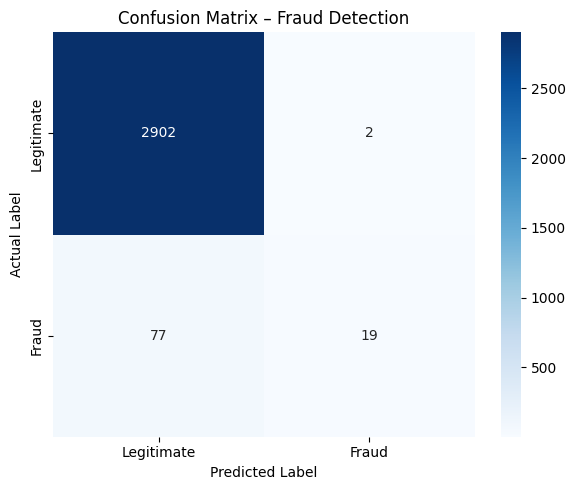

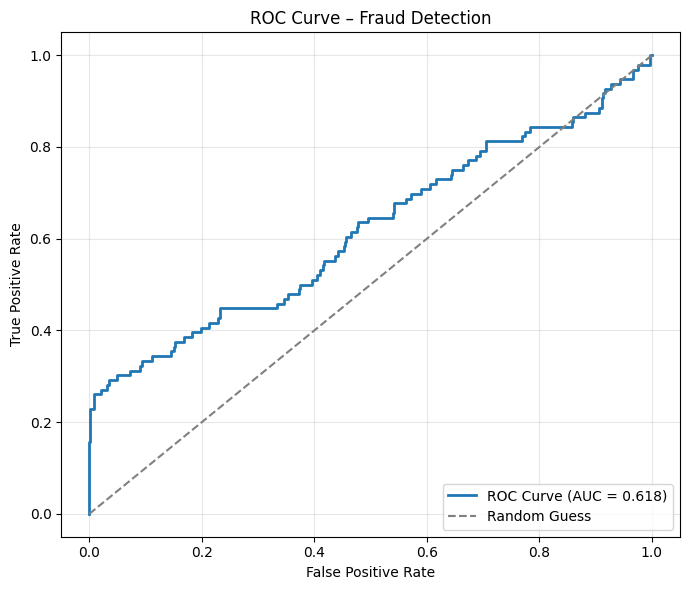


ROC-AUC Score: 0.6182


In [35]:
# evaluation and result show
evaluate_model(model, X_test, y_test)

In [36]:
print("Results folder:")
print(os.listdir("results"))

Results folder:
['confusion_matrix.png', 'roc_curve.png']


In [37]:
## for graph-based results
from src.graph import build_transaction_graph, compute_graph_features

G = build_transaction_graph(df)

df_graph = compute_graph_features(df.copy(), G)

df_graph_features = engineer_features(df_graph)


In [39]:
## test/train split again

split = int(len(df_graph_features) * 0.8)

Xg = df_graph_features.drop(columns=[
    "transaction_id",
    "user_id",
    "merchant_id",
    "device_id",
    "timestamp",
    "is_fraud"
])
yg = df_graph_features["is_fraud"]

Xg_train, Xg_test = Xg.iloc[:split], Xg.iloc[split:]
yg_train, yg_test = yg.iloc[:split], yg.iloc[split:]


In [40]:
## train again
graph_model = train_model(Xg_train, yg_train)


graph based results

Classification Report:

              precision    recall  f1-score   support

  Legitimate       0.97      1.00      0.99      2904
       Fraud       0.91      0.21      0.34        96

    accuracy                           0.97      3000
   macro avg       0.94      0.60      0.66      3000
weighted avg       0.97      0.97      0.97      3000



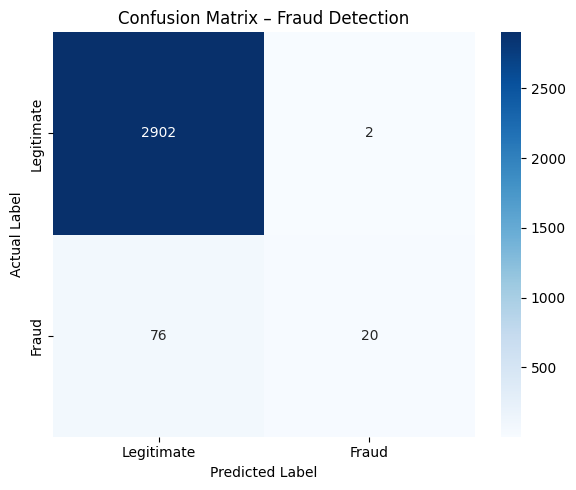

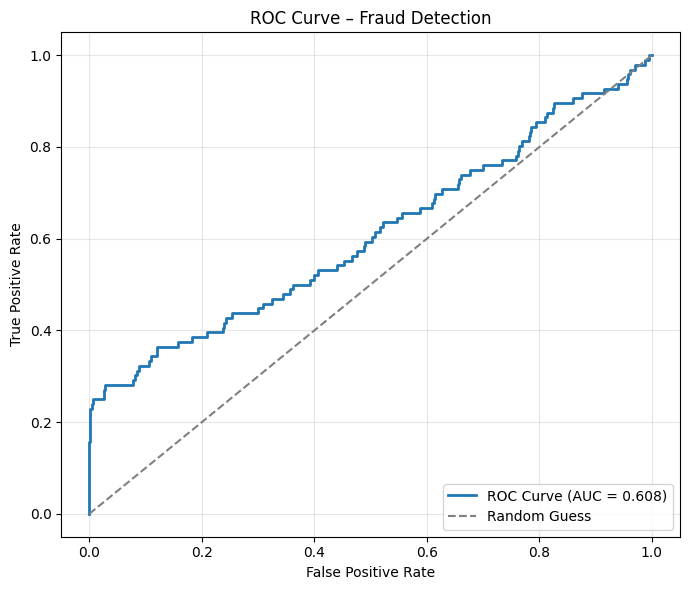


ROC-AUC Score: 0.6084


In [41]:
## final graph-based result show
print("graph based results")
evaluate_model(graph_model, Xg_test, yg_test)